In [1]:
# activate autoreload
%load_ext autoreload
%autoreload 2

# check if session is in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print('Google Colab session!')
except:
    IN_COLAB = False
    print('Not a Google Colab session.')

# add src path to the notebook
import os
import sys
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    PROJECT_ROOT: str = '/content/drive/MyDrive/papers/2025b_spatially-explicit-active-learning'
    !pip install contextily esda deep-translator h3pandas h3~=3.0 datasets
else:
    PROJECT_ROOT: str = os.path.dirname(os.path.abspath(os.path.dirname("__file__")))
if PROJECT_ROOT not in sys.path:
    sys.path.append(os.path.join(PROJECT_ROOT))
print(PROJECT_ROOT)

Google Colab session!
Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.4/138.4 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.8 MB/s eta 0:00:00
  Created wheel for h3pandas: fi

# 2023 Emilia Romagna Floods : Data Preparation
In this notebook, we prepare the data set of disaster-tweets regarding the 2023 Emilia Romagna flood in Italy.

In [2]:
import os
import torch
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from src.utils import clean_text_bert, build_dataset_relatedness, translate_google
sns.set_style('whitegrid')
tqdm.pandas()


# set data path
DATA_PATH: str = os.path.join(PROJECT_ROOT, 'data')
print(f'Data path: {DATA_PATH}')

# set torch device
device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    print(torch.cuda.get_device_name(0))

Data path: /content/drive/MyDrive/papers/2025b_spatially-explicit-active-learning/data


## 1. Load Data
First, let's read in the data.

In [ ]:
italy_tweets: gpd.GeoDataFrame = gpd.read_file(os.path.join(DATA_PATH, 'raw', 'emilia_romagna', 'tweets_emilia_romagna_2023.gpkg')).rename(
    columns={'geometry': 'geom'}
)
italy_tweets = italy_tweets[['message_id', 'date', 'text', 'tweet_lang', 'geom', 'photo_url']]
print(italy_tweets.shape)

(43443, 6)


Let's go ahead with pre-processing.

In [ ]:
# create a normalised representation of each post
if 'text_raw' not in italy_tweets.columns:
    italy_tweets['text_raw'] = italy_tweets['text'].copy()
    italy_tweets['text'] = italy_tweets['text'].progress_apply(clean_text_bert)

  0%|          | 0/43443 [00:00<?, ?it/s]

100%|██████████| 43443/43443 [00:00<00:00, 324730.58it/s]


We can then merge the already labelled tweets with the full set of tweets.

In [ ]:
italy_gdf: gpd.GeoDataFrame = gpd.GeoDataFrame(
    data=italy_tweets, geometry='geom', crs=4326
)
italy_gdf.head()

,message_id,date,text,tweet_lang,geom,photo_url,text_raw
0,1653419375867703298,2023-05-02 15:21:12,"@user @user Cucinare fa bene, mantiene giovani",it,"POLYGON ((11.14965 43.72596, 11.33998 43.72596...",None,@luisannamesseri @paologoriburde Cucinare fa b...
1,1653462600741470224,2023-05-02 18:12:58,@user Le scale sono la prima cosa che notano t...,it,"POLYGON ((12.09448 44.02032, 12.36229 44.02032...",None,@21lettere Le scale sono la prima cosa che not...
2,1653464060728336385,2023-05-02 18:18:46,@user Poi dirà che sono lordi.,it,"POLYGON ((10.49105 44.62427, 10.77335 44.62427...",None,@carovana12 Poi dirà che sono lordi.
3,1653468181728460801,2023-05-02 18:35:09,@user @user E c mancass pur! T'anna pavá lor a...,pt,"POLYGON ((11.22961 44.42115, 11.43370 44.42115...",None,@smilingPamPam @vetustissima E c mancass pur! ...
4,1653469402749124636,2023-05-02 18:40:00,@user @user http,qme,"POLYGON ((11.01313 43.81594, 11.16941 43.81594...",https://t.co/NpNMnqBA08,@IzauraMagyar @Sinnaig https://t.co/NpNMnqBA08


## 2. Visualisation
Okay, so let's look at the spatial and temporal distribution of tweets now.

In [ ]:
print(f'Date range: {italy_gdf["date"].min()} to {italy_gdf["date"].max()}')

Date range: 2023-04-24 00:51:26 to 2023-05-30 23:54:44


Text(0.5, 1.0, 'Tweet density')

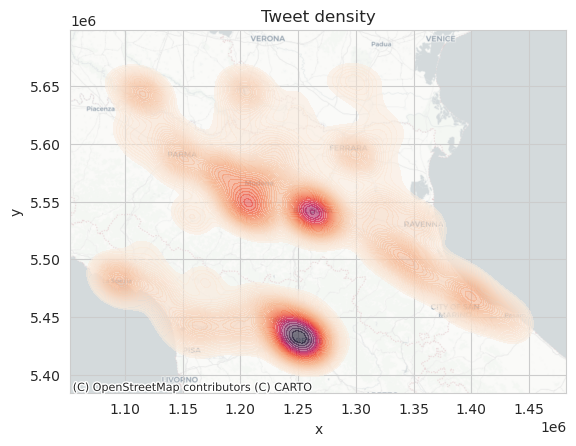

In [ ]:
# visualise a simple kde-plot
italy_gdf = italy_gdf.to_crs(3857)
italy_gdf['centroid'] = italy_gdf['geom'].centroid
italy_gdf['x'] = italy_gdf['centroid'].x
italy_gdf['y'] = italy_gdf['centroid'].y
italy_gdf = italy_gdf.to_crs(4326)

# then visualise the spatial tweet distribution
fig, ax = plt.subplots()
kde_plt = sns.kdeplot(x='x', y='y', data=italy_gdf,
                n_levels=50, fill=True, alpha=0.55,
                cmap='rocket_r', ax=ax)
italy_gdf.to_crs(3857).sample(10).plot(color='none', edgecolor='none', ax=ax, linewidth=0.2, legend=True)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title(f"Tweet density")

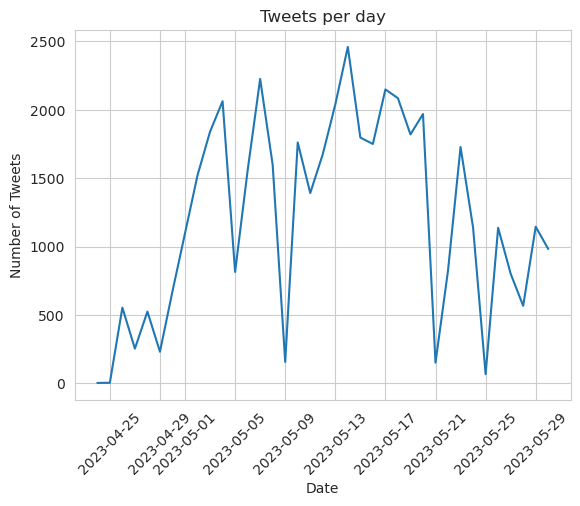

In [ ]:
# and also the temporal distribution
daily_counts: pd.DataFrame = italy_gdf.groupby(italy_gdf['date'].dt.date).size()

# plot the daily tweet count
ax = sns.lineplot(x=daily_counts.index, y=daily_counts.values)
ax.set_title(f"Tweets per day")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Tweets")
ax.tick_params(axis='x', rotation=45)

In [ ]:
italy_gdf.to_parquet(os.path.join(DATA_PATH, 'processed', 'emilia_romagna', 'emilia_romagna_tweets.parquet'))

## 3. Relatedness Classification
Lastly, we need relatedness labels to create our labelling samples. The goal is to use a 66%/33% split of the classes "1" and "0" to create our samples to label.

In [4]:
italy_gdf: gpd.GeoDataFrame = gpd.read_parquet(os.path.join(DATA_PATH, 'processed', 'use_cases', 'emilia_romagna', 'emilia_romagna_tweets.parquet'))
print(italy_gdf.shape)
italy_gdf.head()

(43443, 10)


,message_id,date,text,tweet_lang,geom,photo_url,text_raw,centroid,x,y
0,1653419375867703298,2023-05-02 15:21:12,"@user @user Cucinare fa bene, mantiene giovani",it,"POLYGON ((11.14965 43.72596, 11.33998 43.72596...",None,@luisannamesseri @paologoriburde Cucinare fa b...,POINT (1251767.325 5431572.638),1.251767e+06,5.431573e+06
1,1653462600741470224,2023-05-02 18:12:58,@user Le scale sono la prima cosa che notano t...,it,"POLYGON ((12.09448 44.02032, 12.36229 44.02032...",None,@21lettere Le scale sono la prima cosa che not...,POINT (1361257.591 5485089.098),1.361258e+06,5.485089e+06
2,1653464060728336385,2023-05-02 18:18:46,@user Poi dirà che sono lordi.,it,"POLYGON ((10.49105 44.62427, 10.77335 44.62427...",None,@carovana12 Poi dirà che sono lordi.,POINT (1183570.784 5574327.977),1.183571e+06,5.574328e+06
3,1653468181728460801,2023-05-02 18:35:09,@user @user E c mancass pur! T'anna pavá lor a...,pt,"POLYGON ((11.22961 44.42115, 11.4337 44.42115,...",None,@smilingPamPam @vetustissima E c mancass pur! ...,POINT (1261434.142 5541395.276),1.261434e+06,5.541395e+06
4,1653469402749124636,2023-05-02 18:40:00,@user @user http,qme,"POLYGON ((11.01313 43.81594, 11.16941 43.81594...",https://t.co/NpNMnqBA08,@IzauraMagyar @Sinnaig https://t.co/NpNMnqBA08,POINT (1234674.512 5447297.991),1.234675e+06,5.447298e+06


In [5]:
italy_to_label: gpd.GeoDataFrame = build_dataset_relatedness(gdf=italy_gdf, max_size=10000)
print(italy_to_label.shape)
italy_to_label.head()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/918 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/652 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Device set to use cuda
 38%|███▊      | 3834/10000 [10:17<16:32,  6.21it/s]  


(3834, 13)


,level_0,index,message_id,date,text,tweet_lang,geom,photo_url,text_raw,centroid,x,y,related
0,0,34504,1659995582901919746,2023-05-20 18:52:42,@user they are more desirable😊,en,"POLYGON ((9.87849 44.04794, 9.96652 44.04794, ...",None,@ArtsOfExistence they are more desirable😊,POINT (1104567.8143754932 5476974.199963767),1.104568e+06,5.476974e+06,0
1,1,31819,1659524796869234691,2023-05-19 11:41:58,@user @user @user 東京横断させるのかw,ja,"POLYGON ((11.22961 44.42115, 11.4337 44.42115,...",None,@GeckoMoonlight @timiri6666 @BlindedTotally 東京...,POINT (1261434.1423686962 5541395.276388921),1.261434e+06,5.541395e+06,0
2,2,24459,1658011855074340865,2023-05-15 07:30:05,@user @user Eh Eh Eh allora è un po’ complicat...,it,"POLYGON ((11.01313 43.81594, 11.16941 43.81594...",None,@superbadile @eziomauro Eh Eh Eh allora è un p...,POINT (1234674.5119527876 5447297.991476651),1.234675e+06,5.447298e+06,0
3,3,31701,1659508315938861057,2023-05-19 10:36:29,Un po’ di polemica che mi distrae mentre dovre...,it,"POLYGON ((11.22961 44.42115, 11.4337 44.42115,...",https://t.co/8SXSTzENIi,Un po’ di polemica che mi distrae mentre dovre...,POINT (1261434.1423686962 5541395.276388921),1.261434e+06,5.541395e+06,0
4,4,26540,1658564609761071120,2023-05-16 20:06:32,@user @user @user @user @user @user @user @use...,it,"POLYGON ((11.22961 44.42115, 11.4337 44.42115,...",None,@HeraultTribune @PartiAnimaliste @CRAC_Europe ...,POINT (1261434.1423686962 5541395.276388921),1.261434e+06,5.541395e+06,0


In [6]:
italy_to_label.groupby('related').size()

,0
related,
0,3300
1,534


In [7]:
italy_to_label['centroid'] = gpd.GeoSeries(italy_to_label['centroid'], crs=3857)
italy_to_label.to_parquet(os.path.join(DATA_PATH, 'processed', 'use_cases', 'emilia_romagna', 'emilia_romagna_tweets_to_label.parquet'))

Before storing the final dataframe, let's also translate the tweets to English.

In [3]:
italy_to_label = gpd.read_parquet(os.path.join(DATA_PATH, 'processed', 'use_cases', 'emilia_romagna', 'emilia_romagna_tweets_to_label.parquet'))
italy_to_label['text_en'] = translate_google(texts=italy_to_label['text'])
italy_to_label.head()

100%|██████████| 3834/3834 [55:50<00:00,  1.14it/s]


,level_0,index,message_id,date,text,tweet_lang,geom,photo_url,text_raw,centroid,x,y,related,text_en
0,0,34504,1659995582901919746,2023-05-20 18:52:42,@user they are more desirable😊,en,"POLYGON ((9.87849 44.04794, 9.96652 44.04794, ...",None,@ArtsOfExistence they are more desirable😊,POINT (1104567.814 5476974.2),1.104568e+06,5.476974e+06,0,@user they are more desirable😊
1,1,31819,1659524796869234691,2023-05-19 11:41:58,@user @user @user 東京横断させるのかw,ja,"POLYGON ((11.22961 44.42115, 11.4337 44.42115,...",None,@GeckoMoonlight @timiri6666 @BlindedTotally 東京...,POINT (1261434.142 5541395.276),1.261434e+06,5.541395e+06,0,@user @user @user Are you going to cross Tokyo?
2,2,24459,1658011855074340865,2023-05-15 07:30:05,@user @user Eh Eh Eh allora è un po’ complicat...,it,"POLYGON ((11.01313 43.81594, 11.16941 43.81594...",None,@superbadile @eziomauro Eh Eh Eh allora è un p...,POINT (1234674.512 5447297.991),1.234675e+06,5.447298e+06,0,@user @user Eh Eh Eh then it's a bit complicat...
3,3,31701,1659508315938861057,2023-05-19 10:36:29,Un po’ di polemica che mi distrae mentre dovre...,it,"POLYGON ((11.22961 44.42115, 11.4337 44.42115,...",https://t.co/8SXSTzENIi,Un po’ di polemica che mi distrae mentre dovre...,POINT (1261434.142 5541395.276),1.261434e+06,5.541395e+06,0,A bit of controversy that distracts me when I ...
4,4,26540,1658564609761071120,2023-05-16 20:06:32,@user @user @user @user @user @user @user @use...,it,"POLYGON ((11.22961 44.42115, 11.4337 44.42115,...",None,@HeraultTribune @PartiAnimaliste @CRAC_Europe ...,POINT (1261434.142 5541395.276),1.261434e+06,5.541395e+06,0,@user @user @user @user @user @user @user @use...


In [4]:
italy_to_label.to_parquet(os.path.join(DATA_PATH, 'processed', 'use_cases', 'emilia_romagna', 'emilia_romagna_tweets_to_label.parquet'))